In [41]:
import pandas as pd
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import datasets
from sklearn.metrics import r2_score, f1_score, mean_absolute_error, mean_squared_error, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Будем считать, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (пытаемся моделировать вероятность)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$





Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 



И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



# Метод оптимизации функции потерь

SGD градиентный спуск - стохастический градиентный спуск
MB-GD - мини батч градиентный спуск

Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу 
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.

    


# Формула обновления весов в линейной регрессии с l2 регуляризацией

$$ w_{new} = w_{old} - 2\alpha (\frac{1}{n}X^{T}(Xw_{old} - Y) + \lambda w_{old}) $$

# Формула обновления весов в логистической регрессии с l2 регуляризацией

$$ w_{new} = w_{old} - \alpha (\frac{1}{n}X^{T}(V - Y) + 2\lambda w_{old}) $$



$$ V_{i} = \frac{1}{1+\exp(-\langle x_{i}\cdot w \rangle)} $$

Существует точное выражение для нахождения минимума в методе наименьших квадратов

$w = (X^TX)^{-1}X^TY $

Из-за плохой обусловленности матрицы и того, что умножение матриц выполняется за $O(n^3)$(можно быстрее) такой метод отыскания минимума не применяют на практике

In [2]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    
    X_batch = ""
    y_batch = ""
    num = 0
    if shuffle == True:
        while True:
            ind = rnd.sample([i for i in range(X.shape[0])], batch_size)
            
            yield (num, (X[ind,:], y[ind]))
            num += 1       
    else:
        i = 0
        n = X.shape[0]
        while True:
            ind = [t % n for t in range(i, i + batch_size)]
            i += batch_size
            yield (num, (X[ind,:], y[ind]))
            num += 1


In [3]:
def sigmoid(x):
    """
    Вычисляем значение сигмоиды.
    X - выход линейной модели
    """
    
    sigm_value_x = 1. / (1 + np.exp(-x))
    return sigm_value_x

In [4]:

from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDLinearModels(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, 
                 max_epoch=10, model_type='lin_reg',
                batch_size=1):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тип модели, lin_reg или log_reg
        """
        if model_type != 'lin_reg' and model_type != 'log_reg':
            raise TypeError
            
        self.batch_size = batch_size   
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        """
        
        loss = 0
        if self.model_type == 'log_reg':
            p = sigmoid(np.dot(X_batch, self.weights))
            for i in p:
                if i < 1e-16:
                    i = 0.0001
            
                if 1 - i < 1e-16:
                    i = 0.9999
                
            loss = np.dot(y_batch, np.log(p))
            loss += np.dot(1 - y_batch, np.log(1 - p))
            loss *= -1
            loss /= y_batch.shape[0]
        
        else:
            loss = ((y_batch - np.dot(X_batch, self.weights)) ** 2).sum()
            
            loss /= y_batch.shape[0]
            
        return loss 
    
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        """
        loss_grad = 0
        if self.model_type == 'lin_reg':
            loss_grad = np.dot(X_batch, self.weights) 
            loss_grad -= y_batch
            loss_grad = np.dot(X_batch.transpose(), loss_grad)
            loss_grad /= y_batch.shape[0]
            
            temp = self.weights[0]
            self.weights[0] = 0.
            loss_grad += self.C * self.weights
            self.weights[0] = temp
                
            loss_grad *= 2
            
        else:
            V = sigmoid(np.dot(X_batch, self.weights))
            loss_grad = V - y_batch
            loss_grad = np.dot(X_batch.transpose(), loss_grad)
            loss_grad /= y_batch.shape[0]
            
            temp = self.weights[0]
            self.weights[0] = 0.
            loss_grad += 2 * self.C * self.weights
            self.weights[0] = temp
         
        return loss_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= new_grad * self.alpha
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        
        X = np.array(X)
        y = np.array(y)
        ones = np.array([1 for i in range(X.shape[0])]).reshape((-1,1))
        X = np.concatenate((ones, X), axis=1)

        self.weights = np.random.uniform(-10, 10, X.shape[1])
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, True, self.batch_size)
            iterator = 0
            for batch_num, new_batch in new_epoch_generator:
                X_batch = new_batch[0]

                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                
                self.update_weights(batch_grad)
                batch_loss = self.calc_loss(X_batch, y_batch)
                
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)

                if iterator > X.shape[0] / self.batch_size:
                    break
                iterator+=1
                
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        '''
        y_hat = 0
        if self.model_type == "lin_reg":
            y_hat = np.dot(X, self.weights[1:]) + self.weights[0]
        
        else:
            y_hat = sigmoid(np.dot(X, self.weights[1:]) + self.weights[0])
        
        return y_hat

# Линейная регрессия, Бостон датасет

In [5]:
data = datasets.load_boston()

In [8]:
X = data["data"]
X = StandardScaler().fit_transform(X)
y = data["target"]

In [31]:
%%time
y_ans = []
for train_index, test_index in KFold(n_splits=10).split(X):
    mdl = MySGDLinearModels(batch_generator, 
                      C=0.01, 
                      alpha=0.001,
                      max_epoch=1000,
                      model_type='lin_reg',
                      batch_size=10)
    X_train = X[train_index,:]
    y_train = y[train_index]

    X_test = X[test_index,:]
    y_test = y[test_index]
    
    mdl.fit(X_train, y_train)
    y_ans += list(mdl.predict(X_test))


Wall time: 1min 15s


In [32]:
r2_score(y_ans, y), mean_absolute_error(y_ans, y), mean_squared_error(y_ans, y)

(0.4236635998210556, 3.9713588204008774, 34.149579731997676)

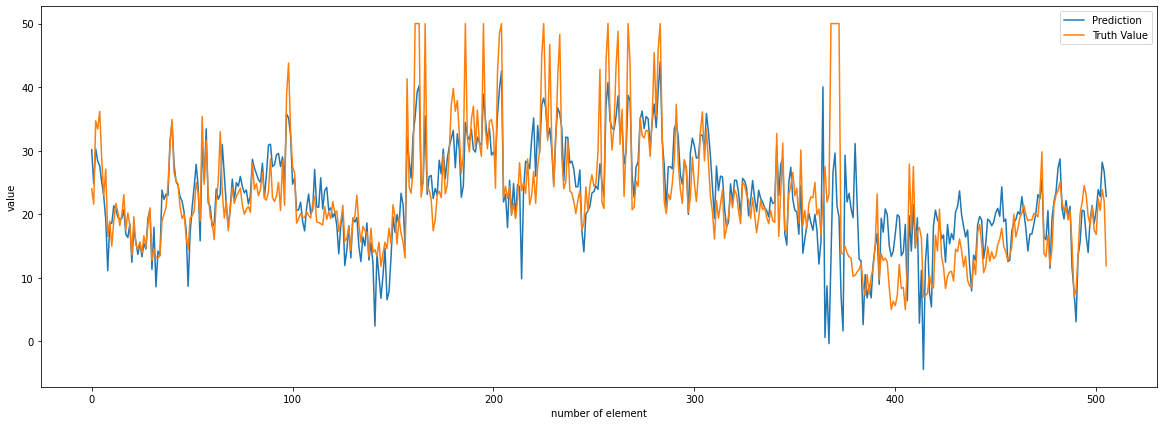

In [33]:
plt.rcParams["figure.figsize"] = (20,7)

plt.plot(y_ans)
plt.plot(y)
plt.xlabel("number of element")
plt.legend(["Prediction","Truth Value"])
plt.ylabel("value")
plt.show()

In [34]:
%%time
y_ans = []
for train_index, test_index in KFold(n_splits=10).split(X):
    mdl = Ridge(1)
    X_train = X[train_index,:]
    y_train = y[train_index]

    X_test = X[test_index,:]
    y_test = y[test_index]
    mdl.fit(X_train, y_train)
#     print(r2_score(mdl.predict(X_train), y_train))
    y_ans += list(mdl.predict(X_test))

Wall time: 22.6 ms


In [35]:
r2_score(y_ans, y), mean_absolute_error(y_ans, y), mean_squared_error(y_ans, y)

(0.44077611520440463, 3.985193842085916, 34.38899713289861)

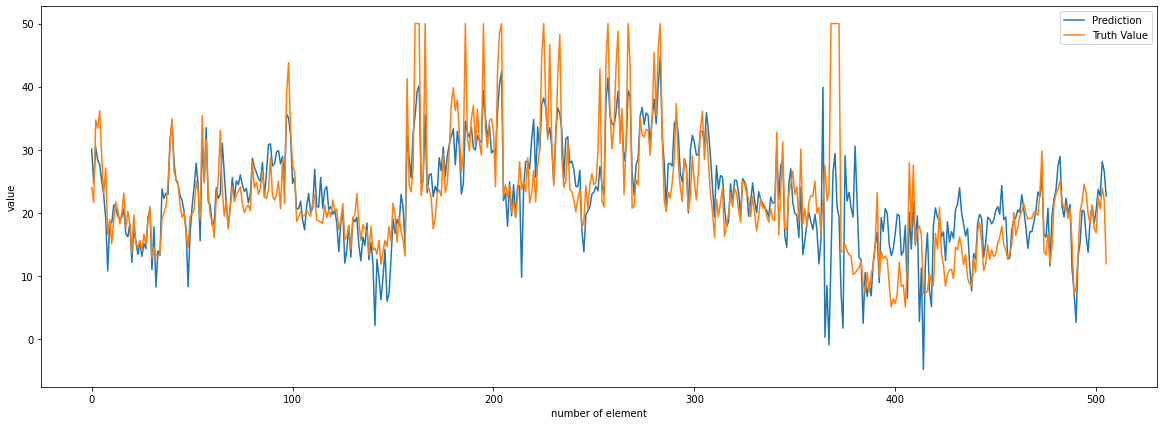

In [36]:
plt.rcParams["figure.figsize"] = (20,7)

plt.plot(y_ans)
plt.plot(y)
plt.xlabel("number of element")
plt.legend(["Prediction","Truth Value"])
plt.ylabel("value")
plt.show()

### Видим, на кроссвалидации примерно одинаковое качество и по графику и по метрикам

# Логистическая регрессия датасет с раком

In [37]:
data = datasets.load_breast_cancer()

In [38]:
X = data["data"]
X = StandardScaler().fit_transform(X)
y = data["target"]

In [39]:
def ReturnClasses(prob, threshold):
    classes = []
    for i in prob:
        
        if i > threshold:
            classes.append(1)
        else:
            classes.append(0)
            
    return classes
    

In [40]:
%%time
probs = []
for train_index, test_index in KFold(n_splits=10).split(X):
    mdl = MySGDLinearModels(batch_generator, 
                      C=0.01, 
                      alpha=0.001,
                      max_epoch=1000,
                      model_type='log_reg',
                      batch_size=10)
    X_train = X[train_index,:]
    y_train = y[train_index]

    X_test = X[test_index,:]
    y_test = y[test_index]
    
    mdl.fit(X_train, y_train)
#     print(mdl.predict(X_test))
    probs += list(mdl.predict(X_test))


<ipython-input-4-daabd9455ca5>:44: RuntimeWarning: divide by zero encountered in log
  loss += np.dot(1 - y_batch, np.log(1 - p))


Wall time: 1min 56s


In [43]:
y_ans = ReturnClasses(probs, 0.1)

In [45]:
f1_score(y_ans, y), roc_auc_score(y, probs)

(0.9462365591397849, 0.9790444479678664)

In [46]:
%%time
probs = []
for train_index, test_index in KFold(n_splits=10).split(X):
    mdl = LogisticRegression(C=1)
    X_train = X[train_index,:]
    y_train = y[train_index]

    X_test = X[test_index,:]
    y_test = y[test_index]
    
    mdl.fit(X_train, y_train)
#     print(mdl.predict(X_test))
    probs += list(mdl.predict(X_test))

Wall time: 318 ms


In [47]:
y_ans = ReturnClasses(probs, 0.1)

In [48]:
f1_score(y_ans, y), roc_auc_score(y, probs)

(0.9819193324061197, 0.9731713440093017)

### Видим, на кроссвалидации примерно одинаковое качество